# Training and Testing Medical Concept LSTMs

In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
from gensim.models import KeyedVectors
import time
import pandas as pd
import csv
from torchcrf import CRF

The `GloveModel` is a pretrained word embedding model used to convert each word into a 300 dimensional vector. Change `GLOVE_PATH` to point to the downloaded glove model. Instructions for download are in the README.md documentation.

In [ ]:
GLOVE_PATH ='../../glove.6B.300d.txt'
gloveModel = KeyedVectors.load_word2vec_format(GLOVE_PATH, binary = False, no_header = True)

Read in the csv files which should have been created from *DataFrameCreator.ipynb*. Split off 10% of the training data to use as a validation set.

In [ ]:
from sklearn.model_selection import train_test_split

pandasDataset = pd.read_csv(f'../TrainingData.csv')
trainData, valData = train_test_split(pandasDataset, test_size=0.1)
testData = pd.read_csv(f'../TestData.csv')

Create a custom dataset that loads in each line of text and outputs the feature vector using the `GloveModel`. Create a custom dataset for training, validation, and test data.

In [ ]:
from torch.utils.data import Dataset

class CustomDataset(Dataset):

    def __init__(self, data, embeddingModel):
        self.data = data
        self.embeddingModel = embeddingModel
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        
        data = self.data.iloc[index]
        text = data['Text'].split(' ')
        
        label = data['Label']
        label = [int(l) for l in label.strip('[]').split(', ')]
        
        
        x = torch.zeros((len(text), 300), device='cuda', dtype=torch.float)
        y = torch.zeros((len(label)), device='cuda', dtype=torch.long)
        
        for i in range(len(text)):
            if text[i] in self.embeddingModel.key_to_index:
                x[i][0:300] = torch.tensor(self.embeddingModel.get_vector(text[i]))        
                
        for i in range(len(label)):
            y[i] = label[i]
            
#         for i in range(len(text)):
#             for j in range(min(len(text[i]), 50)):
#                 x[i][300+j] = ord(text[i][j])
            
        return x, y
    
    
    def getText(self, index):
        return self.data.iloc[index]['Text']
        
    def getLabel(self, index):
        return self.data.iloc[index]['Label']

In [ ]:
trainDataset = CustomDataset(trainData, gloveModel)
valDataset = CustomDataset(valData, gloveModel)
testDataset = CustomDataset(testData, gloveModel)

Use a collate function to pad the sequence of words. This is needed to train the network in batches.

In [ ]:
from torch.nn.utils.rnn import pad_sequence

def collate_fn(data):
    text, labels = zip(*data)
    text = pad_sequence(text, batch_first=True)
    labels = pad_sequence(labels, batch_first=True)
    
    return text, labels

Create each of the data loaders using a batch size of 32.

In [ ]:
from torch.utils.data import DataLoader

feature_size = 300
batchSize = 32

train_loader = DataLoader(trainDataset, batch_size=batchSize, collate_fn=collate_fn, shuffle=True)
val_loader = DataLoader(valDataset, batch_size=batchSize, collate_fn=collate_fn)
test_loader = DataLoader(testDataset, batch_size=batchSize, collate_fn=collate_fn)

text, labels = next(iter(train_loader))
print(text.size())

Define all 5 of the LSTM models. Each model has the following architecture. Each of the LSTMs take in the embedded words as inputs. The output of the LSTM is then fed into a CRF. This is what makes the final predition. The output is in the IOB format (Inside, Outside, Beginning). The output can be 1 of 7 classes.  B-problem, I-problem, B-test, I-test, B-treatment, I-treatment, and Outside.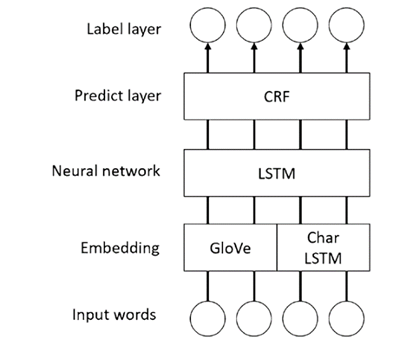

In [ ]:
class uniLSTM(nn.Module):
    def __init__(self, feature_size):
        super().__init__()
        
        self.name = "uniLSTM"
        self.lstm = nn.LSTM(feature_size, feature_size, 1, batch_first=True)
        self.fc = nn.Linear(in_features=feature_size, out_features=7)
        self.crf = CRF(7, batch_first=True)
    
    def logLikelihood(self, x, tags):
        output, _ = self.lstm(x)
        y = self.fc(output) 
        loss = -self.crf(y, tags)
        return loss
        
    def forward(self, x):
        output, _ = self.lstm(x)
        y = self.fc(output)
        y_hat = self.crf.decode(y)
        return torch.tensor(y_hat)

In [ ]:
class biLSTM(nn.Module):
    def __init__(self, feature_size):
        super().__init__()
        
        self.name = "biLSTM"
        self.lstm = nn.LSTM(feature_size, feature_size, 1, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(in_features=2*feature_size, out_features=7)
        self.crf = CRF(7, batch_first=True)
    
    def logLikelihood(self, x, tags):
        output, _ = self.lstm(x)
        y = self.fc(output) 
        loss = -self.crf(y, tags)
        return loss
        
    def forward(self, x):
        output, _ = self.lstm(x)
        y = self.fc(output)
        y_hat = self.crf.decode(y)
        return torch.tensor(y_hat)

In [ ]:
import torch.nn.functional as F
class attnLSTM(nn.Module):
    def __init__(self, feature_size, max_length=250):
        super().__init__()
        
        self.name = "attnLSTM"
        self.attn = nn.Linear(feature_size, max_length)
        self.lstm = nn.LSTM(feature_size, feature_size, 1, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(in_features=2*feature_size, out_features=7)
        self.attn_combine = nn.Linear(8, 7)
        self.crf = CRF(7, batch_first=True)
    
    def logLikelihood(self, x, tags):
        y = self.forwardUpToCrf(x)
        loss = -self.crf(y, tags)
        return loss
    
    def forwardUpToCrf(self, x):
        output, _ = self.lstm(x)
        
        alpha = self.attn(x)
        alphaVec = torch.sum(alpha, dim=1)
        alphaVec = F.softmax(alphaVec, dim=1)
        alphaVec = torch.unsqueeze(alphaVec, 2)
        alphaVec = torch.index_select(alphaVec, 1, torch.linspace(0, x.size()[1]-1, x.size()[1], dtype=torch.int).cuda())
        
        #print(alphaVec.size())
        #print(alphaVec[0])
        
        y = self.fc(output)
        y = F.relu(y)
        #print(y[0])
        y = self.attn_combine(torch.cat((y, alphaVec),2))
        #y = self.attn_combine(y)
        return y
        
    def forward(self, x):
        y = self.forwardUpToCrf(x)
        y_hat = self.crf.decode(y)
        return torch.tensor(y_hat)

In [ ]:
class stackedLSTM(nn.Module):
    def __init__(self, feature_size):
        super().__init__()
        
        self.name = "stackedLSTM"
        self.lstm = nn.LSTM(feature_size, feature_size, 4, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(in_features=2*feature_size, out_features=7)
        self.crf = CRF(7, batch_first=True)
    
    def logLikelihood(self, x, tags):
        output, _ = self.lstm(x)
        y = self.fc(output) 
        loss = -self.crf(y, tags)
        return loss
        
    def forward(self, x):
        output, _ = self.lstm(x)
        y = self.fc(output)
        y_hat = self.crf.decode(y)
        return torch.tensor(y_hat)

In [ ]:
class fullyConnectedLSTM(nn.Module):
    def __init__(self, feature_size):
        super().__init__()
        
        self.name = "fullyConnectedLSTM"
        self.lstm1 = nn.LSTM(feature_size, feature_size, 1, batch_first=True, bidirectional=True)
        self.lstm2 = nn.LSTM(6*feature_size, feature_size, 1, batch_first=True, bidirectional=True)
        self.lstm3 = nn.LSTM(6*feature_size, feature_size, 1, batch_first=True, bidirectional=True)
        self.lstm4 = nn.LSTM(6*feature_size, feature_size, 1, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(in_features=2*feature_size, out_features=7)
        self.crf = CRF(7, batch_first=True)
    
    def logLikelihood(self, x, tags):
        output = self.computeOutput(x)
        y = self.fc(output) 
        loss = -self.crf(y, tags)
        return loss
    
    def createFCVector(self, x):
        zeros = torch.zeros((x.size(dim=0),1,x.size(dim=2))).cuda()
        indices = torch.linspace(0, x.size(dim=1)-1, x.size(dim=1), dtype=torch.int).cuda()     
        x_prev = torch.cat((zeros, x), dim=1)
        x_next = torch.cat((x, zeros), dim=1)
        x_prev = torch.index_select(x_prev, 1, indices)
        x_next = torch.index_select(x_next, 1, indices+1)
        return torch.cat((x_prev, x, x_next), dim=2)
    
    def computeOutput(self, x):
        x1, _ = self.lstm1(x)
        x1 = self.createFCVector(x1)
        x2, _ = self.lstm2(x1)
        x2 = self.createFCVector(x2)
        x3, _ = self.lstm3(x2)
        x3 = self.createFCVector(x3)     
        output, _ = self.lstm4(x3)
        return output
        
    def forward(self, x):
        output = self.computeOutput(x)
        y = self.fc(output)
        y_hat = self.crf.decode(y)
        return torch.tensor(y_hat)

Define the evaluation function. This function returns the precision, recall, F1-score, and accuracy.

In [ ]:
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, accuracy_score

def eval_model(model, val_loader):

    model.eval()
    y_pred = torch.LongTensor()
    y_score = torch.Tensor()
    y_true = torch.LongTensor()
    model.eval()
    for x, y in val_loader:
        y_hat = model(x)
        y = torch.flatten(y, end_dim=1)
        y_hat = torch.flatten(y_hat, end_dim=1)
        y_pred = torch.cat((y_pred,  y_hat.detach().to('cpu')), dim=0)
        y_true = torch.cat((y_true, y.detach().to('cpu')), dim=0)

    [p, r, f, _] = precision_recall_fscore_support(y_true, y_pred, average='macro', zero_division=1)
    acc = accuracy_score(y_true, y_pred) 
    return p, r, f, acc

    

Define the training function. In this function, data is saved to a csv file to be used for plotting.

In [ ]:
def train(model, train_loader, n_epochs):
    s = torch.cuda.Stream()
    s.wait_stream(torch.cuda.current_stream())
    
    
    file = open(model.name + "PlotData.csv", "w", newline='', encoding='utf-8')
    writer = csv.writer(file)
    writer.writerow(["Epoch", "Training Loss", "Training Accuracy", "Val Accurracy", 
                     "Val Precision", "Val Recall", "Val F1", "Time"])
    file.flush()
    best_val_f1 = 0
    best_model_state = model.state_dict()

    with torch.cuda.stream(s):
        for epoch in range(n_epochs):
            tic = time.perf_counter()
            model.train()
            train_loss = 0
            train_acc = 0
            correct_results = 0
            num_examples = 0
            for x, y in train_loader:
                optimizer.zero_grad()
                loss = model.logLikelihood(x,y)
                num_examples += torch.numel(y)
                
                loss.backward()
                optimizer.step()
                train_loss += loss.item()

            train_loss = train_loss / len(train_loader)
            toc = time.perf_counter()
            #train_acc = correct_results.item() / num_examples
            print('Epoch: {} \t Training Loss: {:.6f} \t Training Acc: {:.6f}'.format(epoch+1, train_loss, train_acc)) 
            p, r, f, acc = eval_model(model, val_loader)
            print('Epoch: {} \t Accurracy: {:.4f} \t Precision: {:.4f} \t Recall: {:.4f} \t F1: {:.4f} \t Time: {:.4f}'
                  .format(epoch+1,acc, p, r, f, toc-tic))
                
            writer.writerow([epoch+1, train_loss, train_acc, acc, p, r, f, toc-tic])
            file.flush()
            
            if f > best_val_f1:
                best_val_f1 = f
                torch.save(model, model.name + ".pt")
    
    torch.cuda.current_stream().wait_stream(s)
    model = torch.load(model.name + ".pt")

    file.close()

### EVALUTE MODEL

Choose whether to train a new model or to use one of the existing.

In [ ]:

trainNewModel = True
if trainNewModel:
#     model = uniLSTM(feature_size).cuda()
#     model = biLSTM(feature_size).cuda()
#     model = attnLSTM(feature_size).cuda()
#     model = stackedLSTM(feature_size).cuda()
    model = fullyConnectedLSTM(feature_size).cuda() 

    n_epochs = 20
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    train(model, train_loader, n_epochs)
else:
#     model = torch.load("uniLSTM.pt")
#     model = torch.load("biLSTM.pt")
#     model = torch.load("attnLSTM.pt")
#     model = torch.load("stackedLSTM.pt")
     model = torch.load("fullyConnectedLSTM.pt")

print(model)
p, r, f, acc = eval_model(model, test_loader)
print('[TEST] Accurracy: {:.4f} \t Precision: {:.4f} \t Recall: {:.4f} \t F1: {:.4f}'.format(acc, p, r, f))


Test an example line of a medical record and see how the model classifies the data

In [ ]:
index = 117
print(testDataset.getText(index))
print(testDataset.getLabel(index))
x, _ = testDataset[index]
x = x.unsqueeze(0)
y_hat = model(x)
print(y_hat.tolist())


Save the evaluation metrics to a csv file

In [ ]:

file = open(model.name + "EvalData.csv", "w", newline='', encoding='utf-8')
writer = csv.writer(file)
writer.writerow(["DataSet", "Accuracy",  "Precision", "Recall", "F1"])
p, r, f, acc = eval_model(model, train_loader)
print('[TRAINING] Accurracy: {:.4f} \t Precision: {:.4f} \t Recall: {:.4f} \t F1: {:.4f}'.format(acc, p, r, f))
writer.writerow(["Training", acc, p, r, f])
p, r, f, acc = eval_model(model, val_loader)
print('[VAL] Accurracy: {:.4f} \t Precision: {:.4f} \t Recall: {:.4f} \t F1: {:.4f}'.format(acc, p, r, f))
writer.writerow(["Validation", acc, p, r, f])
p, r, f, acc = eval_model(model, test_loader)
print('[TEST] Accurracy: {:.4f} \t Precision: {:.4f} \t Recall: {:.4f} \t F1: {:.4f}'.format(acc, p, r, f))
writer.writerow(["Test", acc, p, r, f])
file.close()
    